# Training a BurstCCN on MNIST

Import the necessary modules:

In [1]:
from IPython.display import Image
import os
import torch
import torch.nn.functional as F

from tqdm import tqdm

from modules.networks_burstccn import BurstCCN
from modules.optimisers import SGDOptimiser
from datasets import get_mnist_dataset

### Model Schematic

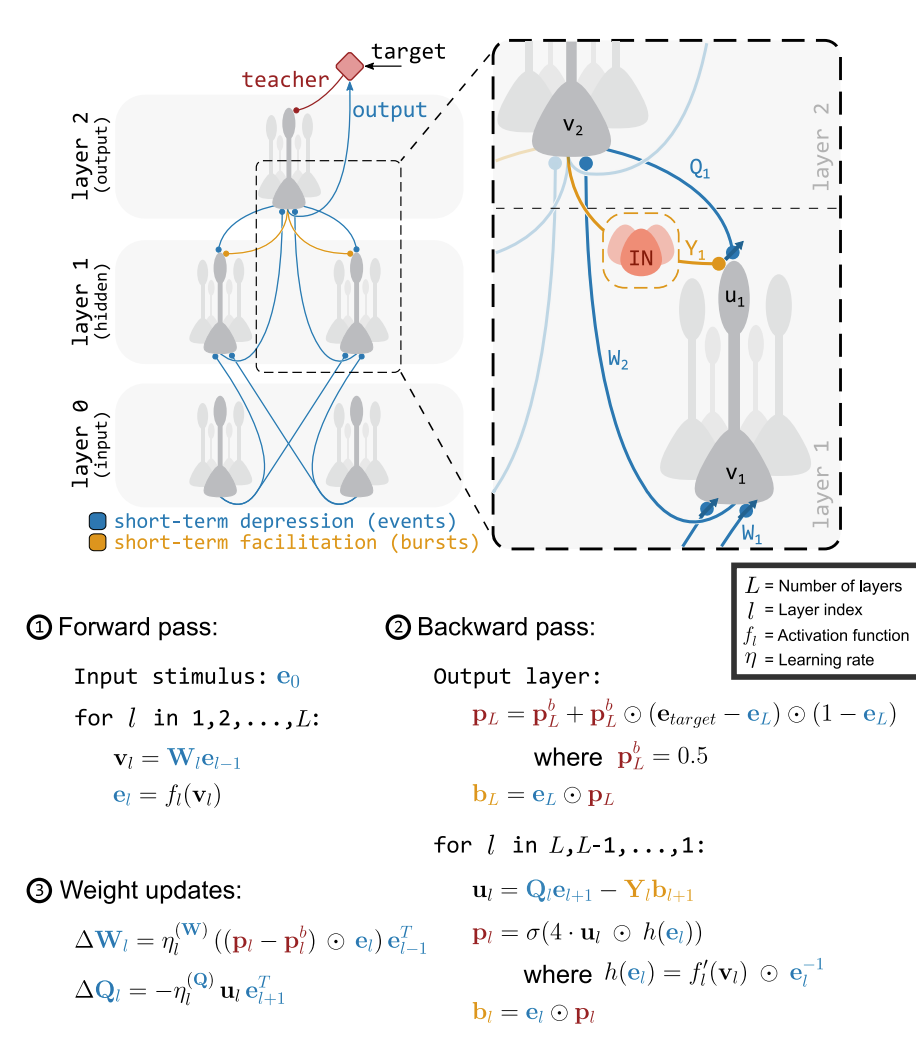

In [2]:
Image("img/burstcnn_schematic.png")

### Setup

Setting up model parameters:

In [3]:
p_baseline = 0.5 # Baseline burst probability
n_hidden_layers = 3
n_hidden_units = 500 # Number of units in each hidden layer

Y_learning = False # Whether to learn the feedback Y weights (default=False corresponding to feedback alignment where they are fixed)

# Y_mode controls how the Y_weights are initialised
# options are 'tied', 'symmetric_init', random_init'
# 'random_init': corresponds to the random feedback weights of feedback alignment (default)
# 'tied': feedback Y weights are kept symmetric with the feedforward weights throughout training
# 'symmetric_init': feedback Y weights are initialised symmetric with feedforward weights but deviate throughout training
Y_mode = 'random_init'

# Y_scale controls the strength of the Y weights and it's interpretation depends on the Y_mode:
# Y_mode='random_init': the scale is the standard deviation of the normal distribution (mean=0) used for initialisation
# Y_mode='symmetric_init' or 'tied': is a controls the ratio of feedforward to feedback weights (Y_scale=1 for exact symmetry)
Y_scale = 0.5

Q_learning = True # Whether to learn the feedback Q weights (default=True such that the Q weights learn to cancel the Y weights)

# Similar to Y_mode, Q_mode controls how the Q weights are initialised
# Options are the same as before: 'tied', 'symmetric_init', random_init'
# 'random_init': corresponds to initially random Q weights that need to align with Y from scratch 
# 'tied': feedback Q weights are kept symmetric with the feedback Y weights (with a -p_baseline constant ratio i.e. Q = -p_baselineY) such that the two pathways cancel in the absense of an error signal
# 'symmetric_init': Q weights are initialised symmetric with the feedback Y weights (as for the 'tied' case) but deviate through training (default)
Q_mode = 'symmetric_init'

# Q_scale controls the strength of the Q weights and it's interpretation depends on the Q_mode:
# Q_mode='random_init': the scale is the standard deviation of the normal distribution (mean=0) used for initialisation
# Q_mode='symmetric_init' or 'tied': is a controls the ratio oY to Q weights (recommended value of Q_scale=1.0 in this case)
Q_scale = 1.0

Setting up training parameters:

In [8]:
working_directory = os.getcwd()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 50
batch_size = 32

lr = 0.3
Y_lr = 0.0
Q_lr = 0.000731

momentum = 0.0
weight_decay = 0.0


data_dir = os.path.join(working_directory, './Data')

train_data_loader, _, test_data_loader = get_mnist_dataset(data_dir, train_batch_size=batch_size, use_validation=False)

Create the model:

In [9]:
model = BurstCCN(n_inputs=784, n_outputs=10, p_baseline=p_baseline,
                              n_hidden_layers=n_hidden_layers,
                              n_hidden_units=n_hidden_units,
                              Y_learning=Y_learning,
                              Y_mode=Y_mode,
                              Y_scale=Y_scale,
                              Q_learning=Q_learning,
                              Q_mode=Q_mode,
                              Q_scale=Q_scale,
                              use_layer_norm=False)

model.to(device)

weight_update_parameters = [layer.weight_grad for layer in model.classification_layers]
bias_update_parameters = [layer.bias_grad for layer in model.classification_layers]

optimiser = SGDOptimiser(weight_parameters=[layer.weight for layer in model.classification_layers],
                        bias_parameters=[layer.bias for layer in model.classification_layers],
                        weight_update_parameters=weight_update_parameters,
                        bias_update_parameters=bias_update_parameters,
                        lr=lr,
                        momentum=momentum,
                        weight_decay=weight_decay)
if Y_learning:
    weight_Y_update_parameters = [layer.weight_Y_grad for layer in model.classification_layers[:-1]]
    Y_optimiser = SGDOptimiser(
        weight_parameters=[layer.weight_Y for layer in model.classification_layers[:-1]],
        weight_update_parameters=weight_Y_update_parameters,
        bias_parameters=None,
        bias_update_parameters=None,
        lr=Y_lr)

if Q_learning:
    weight_Q_update_parameters = [layer.weight_Q_grad for layer in model.classification_layers[:-1]]
    Q_optimiser = SGDOptimiser(
        weight_parameters=[layer.weight_Q for layer in model.classification_layers[:-1]],
        weight_update_parameters=weight_Q_update_parameters,
        bias_parameters=None,
        bias_update_parameters=None,
        lr=Q_lr)

## Training the model

Define the training and testing functions:

In [15]:
def update_model_weights():
    optimiser.step()
    optimiser.zero_grad()

    if Y_learning:
        Y_optimiser.step()
        Y_optimiser.zero_grad()

    if Q_learning:
        Q_optimiser.step()
        Q_optimiser.zero_grad()

    model.apply_weight_constraints()

In [16]:
def train(data_loader):
    model.train()
    
    train_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader)
    for batch_index, (inputs, targets) in enumerate(progress_bar):
        optimiser.zero_grad()
        inputs, targets = inputs.to(model.device), targets.to(model.device)
        t = F.one_hot(targets, num_classes=10).float()

        outputs = model(inputs)

        loss = model.loss(outputs, t)        
        
        model.backward(t)
        
#         optimiser.step()
        update_model_weights()
        
        train_loss += loss
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_description("Train Loss: {:.3f} | Acc: {:.3f}% ({:d}/{:d})".format(train_loss / (batch_index + 1), 100 * correct / total, correct, total))

    return 100.0 * (1.0 - correct / total), train_loss / (batch_index + 1)
    
def test(data_loader):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader)
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(model.device), targets.to(model.device)

            t = F.one_hot(targets, num_classes=10).float()

            outputs = model(inputs)

            loss = model.loss(outputs, t)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar.set_description("Test Loss: {:.3f} | Acc: {:.3f}% ({:d}/{:d})".format(test_loss / (batch_idx + 1), 100 * correct / total, correct, total))

    return 100 * (1.0 - correct / total), test_loss / (batch_idx + 1)

Run the model:

In [ ]:
for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}.")
    train_error, train_loss = train(train_data_loader)
    test_error, test_loss = test(test_data_loader)
    
    print(f"Train: {train_error}, Test: {test_error}")


Epoch 1.


Train Loss: 0.020 | Acc: 88.639% (3035/3424):   5%|██████▊                                                                                                                     | 103/1875 [00:02<00:44, 40.14it/s]